# Digital Image Processing - HW6 - 98722278 - Mohammad Doosti Lakhani
In this notebook, I have solved the assignment's problems which are as follows:

1. This step consists of following tasks:
    1. Read [This paper](http://cseweb.ucsd.edu/~mdailey/Face-Coord/ellipse-specific-fitting.pdf) and summarize it
    2. Convert MATLAB code in fig. 7 to python and extract ellipse parameters of `circle.bmp` and `ellipse.bmp` images.
    3. Plot estimated ellipses using `cv2.ellipse()` method.
2. We want to find the parameters of ellipse using RANSAC algorithm. If only %40 of edges in the image belong to ellipse's edges and we want to obtain the correct parameters with probability of 0.999, how many iterations are required?
3. Do these steps in this task:
    1. Estimates parameters of ellipse using code in task 1 on `ellipse_noise.bmp` image
    2. As there are points that do not blong to ellipse, RANSAC is better solution here. Implement RANSAC
    3. Draw the output on `ellipse_noise.bmp` image
    4. Set the probability of achieving correct parameters of ellipse to 0.99 and run algorithm for 10000 times. In how many of iterations, the estimated parameters are correct?
    5. Analyze your answer

## 1 This step consists of following tasks:
1. Read This paper and summarize it
2. Convert MATLAB code in fig. 7 to python and extract ellipse parameters of circle.bmp and ellipse.bmp images.
3. Plot estimated ellipses using cv2.ellipse() method.

### 1.A Paper Summarization

The proposed method is ellipse specified which means no matter given data, a ellipse will be output. On top of that, it is computationally cheap and robust to noises.
The major reason that this approach is robust and fast is that it uses least-square transformation.

First of all, they use a distance matrix with respect to ellipse equation which is called *distance_matrix*:

Ellipse Equation:
![Ellipse equation](wiki/eq.jpg)

Distance Matrix:
![distance matrix](wiki/dm.jpg)

Now, the parameter `a` is constrained using matrix called `C` which is 6x6 and all these constraints are linear or `C.dot(a) = 1`. But in this paper, constrained `a` is in the way that forces the fitted model to be ellipse. `4*a*c-b**2 = 1` is the equality constraint where `a.T.dot(C).dot(a) = 1`.

So `C` is:

![constraint matrix](wiki/c.jpg)

Based on what they have covered so far, the solution of the quadratically constrained minimization will be:

![constraint minimization](wiki/cm.jpg)


Furthermore, this system can be written as below image where `lambda` is Lagrange multiplier and `S` is `D.T.dot(D)`:

![simplified eigen system](wiki/ss.jpg)

This system can be solved using generalized eigenvectors of `S.dot(a) = lambda*C.dot(a)`.
In the end, if `(lambda, u)` solves `S.dot(a) = lambda*C.dot(a)`, we have:

![mu](wiki/mu.jpg)

Then `a` can be obtained by `a = mu*u`.


### 1.B Direct Least Square of Fitting Ellipse Implementation and Ellipse of `circle.bmp` and `ellipse.bmp`

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [184]:
def direct_least_square(x, y):
    D = np.mat(np.vstack([x**2, x*y, y**2, x, y, np.ones(len(x))])).T
    S = np.dot(D.T, D)
    C = np.zeros((6, 6))
    C[0, 2] = 2
    C[1, 1] = -1
    C[2, 0] = 2
    Z = np.dot(np.linalg.inv(S), C)
    eigen_value, eigen_vec = np.linalg.eig(Z)
    eigen_value = eigen_value.reshape(1, -1)
    pos_r, pos_c = np.where(eigen_value>0 & ~np.isinf(eigen_value))
    a = eigen_vec[:, pos_c]
    return a

def ellipse_center(a):
    a = a.reshape(-1, 1)
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return (int(y0[0, 0])+1, int(x0[0, 0])+1)

def ellipse_angle_of_rotation(a):
    a = a.reshape(-1, 1)
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    return int(np.rad2deg(0.5*np.arctan(2*b/(a-c))[0, 0]))

def ellipse_axis_length(a):
    a = a.reshape(-1, 1)
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return (int(res1[0,0]), int(res2[0, 0]))

In [185]:
# read images
circle = cv2.imread('circle.bmp', 0)
ellipse = cv2.imread('ellipse.bmp', 0)

x_circle, y_circle = circle.nonzero()
x_ellipse, y_ellipse = ellipse.nonzero()

a_circle = direct_least_square(x_circle, y_circle)
a_ellipse = direct_least_square(x_ellipse, y_ellipse)

### 1.C Plot Estimates

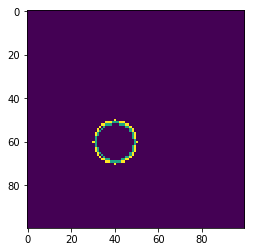

In [186]:
center = ellipse_center(a_circle)
axis = ellipse_axis_length(a_circle)
angle = ellipse_angle_of_rotation(a_circle)
start_angle = 0
end_angle = 360
color = 150
thickness = 1
plt.imshow(cv2.ellipse(circle, center, axis, angle, start_angle, end_angle, color, thickness))

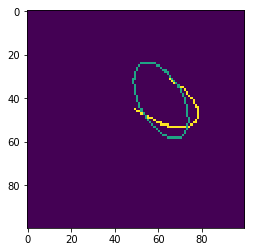

In [187]:
center = ellipse_center(a_ellipse)
axis = ellipse_axis_length(a_ellipse)
angle = ellipse_angle_of_rotation(a_ellipse)
start_angle = 0
end_angle = 360
color = 150
thickness = 1
plt.imshow(cv2.ellipse(ellipse, center, axis, angle, start_angle, end_angle, color, thickness))

## 2 How many Iterations for %40 Inlier Data With 0.999 Correct Estimation Probability?

In [192]:
w = 0.4
p = 0.999
# we need at least 6 points to estimates 6 parameters of the ellipse

k = np.log(1-p) / np.log(1-np.power(w, 6))
print('Number of needed iterations: {}'.format(int(np.ceil(k))))

Number of needed iterations: 1684


## 3 Do these steps in this task:
1. Estimates parameters of ellipse using code in task 1 on ellipse_noise.bmp image
2. As there are points that do not blong to ellipse, RANSAC is better solution here. Implement RANSAC
3. Draw the output on ellipse_noise.bmp image
4. Set the probability of achieving correct parameters of ellipse to 0.99 and run algorithm for 10000 times. In how many of iterations, the estimated parameters are correct?
5. Analyze your answer

### 3.A Estimate Ellipse on `ellipse_noise.bmp` Via Step 1 Code

In [282]:
# read images
ellipse_noise = cv2.imread('ellipse_noise.bmp', 0)
x_ellipse_noise, y_ellipse_noise = ellipse_noise.nonzero()
a_ellipse_noise = direct_least_square(x_ellipse_noise, y_ellipse_noise)

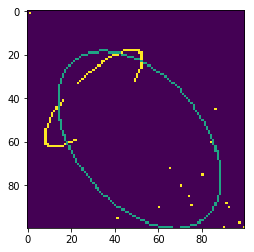

In [196]:
center = ellipse_center(a_ellipse_noise)
axis = ellipse_axis_length(a_ellipse_noise)
angle = ellipse_angle_of_rotation(a_ellipse_noise)
start_angle = 0
end_angle = 360
color = 150
thickness = 1
plt.imshow(cv2.ellipse(ellipse_noise, center, axis, angle, start_angle, end_angle, color, thickness))

### 3.B Implement RANSAC for Ellipse

In [386]:
import random

def ransac(image, max_iter, threshold=5):
    ellipse_noise = image
    data = ellipse_noise
    ics = []
    best_ic = 0
    best_model = None
    xn, yn = data.nonzero()
    nzero = [(x1,y1) for x1, y1 in zip(xn, yn)]
    for epoch in range(max_iter):
        ic = 0
        sample = random.sample(nzero, 6)
        a = direct_least_square(np.array([s[0] for s in sample]), np.array([s[1] for s in sample]))
        for x, y in sample:
            eq = np.mat(np.vstack([x**2, x*y, y**2, x, y, 1])).T
            if np.abs(np.dot(eq, a.reshape(-1,1))) <= threshold:
                ic += 1
        ics.append(ic)
        if ic > best_ic:
            best_ic = ic
            best_model = a
    return a, ics

ellipse_noise = cv2.imread('ellipse_noise.bmp', 0)
a, _ = ransac(ellipse_noise, 500, 5)

### 3.C Draw the Estimated Ellipse Via Ransac

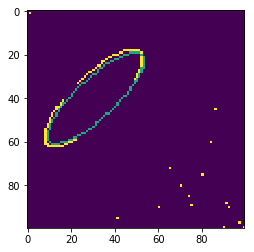

In [387]:
center = ellipse_center(a)
axis = ellipse_axis_length(a)
angle = ellipse_angle_of_rotation(a)
start_angle = 0
end_angle = 360
color = 150
thickness = 1
plt.imshow(cv2.ellipse(ellipse_noise, center, axis, angle, start_angle, end_angle, color, thickness))

### 3.D If P=0.99, With 10000 Iteration, How Many Correct Estimations?

In [402]:
ellipse_noise = cv2.imread('ellipse_noise.bmp', 0)
a, ics = ransac(ellipse_noise, 1000, 5)

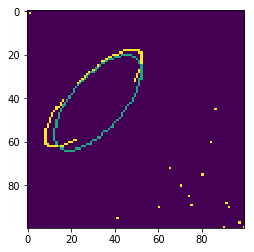

In [403]:
center = ellipse_center(a)
axis = ellipse_axis_length(a)
angle = ellipse_angle_of_rotation(a)
start_angle = 0
end_angle = 360
color = 150
thickness = 1
plt.imshow(cv2.ellipse(ellipse_noise, center, axis, angle, start_angle, end_angle, color, thickness))

I do not know why sometimes my `direct_least_square` function, generates `0` parameters and sometimes `12`, so the could is unstable for high number of loops. So failed this part of training because of lack of time.
Thank you ;-)